# Dataset Augmentation using Stable Diffusion for Better Generalization

## Requirements

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install numpy accelerate opencv-python pandas matplotlib ultralytics diffusers transformers datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xyhq0aur
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xyhq0aur
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=503592ce47bdb46aaea83efae7b1f29dc0b4f7d31e2bb4da6d3a1dfafbc0b59d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_szo3avz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from PIL import Image

import torch
import numpy as np
from segment_anything import build_sam, SamPredictor
from ultralytics import YOLO
from diffusers import StableDiffusionInpaintPipeline

In [3]:
WORKING_DIR = os.getcwd()
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIR, "weights")
ASSETS_DIRECTORY = os.path.join(WORKING_DIR, "assets")

In [4]:
if not os.path.exists(WEIGHTS_DIRECTORY):
    os.mkdir(WEIGHTS_DIRECTORY)

if not os.path.exists(ASSETS_DIRECTORY):
    os.mkdir(ASSETS_DIRECTORY)

In [5]:
# SEGMENTATION_MODEL_KEY = f"{WEIGHTS_DIRECTORY}/sam_vit_h_4b8939.pth"
SEGMENTATION_MODEL_KEY = os.path.join(WEIGHTS_DIRECTORY, "sam_vit_h_4b8939.pth")
DIFFUSION_MODEL_KEY = "stabilityai/stable-diffusion-2-inpainting"
DETECTION_MODEL_KEY = "yolov8s.pt"

In [6]:
!wget -nc -O "$SEGMENTATION_MODEL_KEY" https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-23 19:52:34--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.48, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/weights/sam_vit_h_4b8939.pth’

/content/weights/sa 100%[===================>]   2.39G  88.0MB/s    in 25s     

2024-02-23 19:53:00 (96.5 MB/s) - ‘/content/weights/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Load Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Cat_and_Dog")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


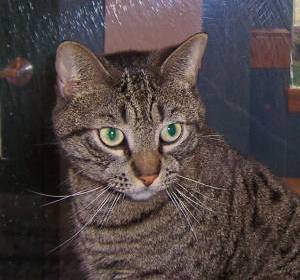

In [8]:
dataset["train"][0]["image"]

# Generator

In [9]:
from typing import Dict, List


class Generator:
    def __init__(self, detection_model: str, segmentation_model: str, diffusion_model: str, device: str = "cuda") -> None:
        self._detection_model = YOLO(detection_model)
        self._segmentation_model = SamPredictor(build_sam(checkpoint=segmentation_model).to(device))
        self._sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
            diffusion_model,
            torch_dtype=torch.float16 if device=="cuda" else torch.float32,
        ).to(device)
        self._device = device

    def detect(self, image: Image) -> List[Dict]:
        results = self._detection_model(image)

        # Extract bounding boxes, classes, names, and confidences
        boxes = results[0].boxes.xyxy.tolist()
        classes = results[0].boxes.cls.tolist()
        names = results[0].names
        confidences = results[0].boxes.conf.tolist()

        formatted_result = []

        # Iterate through the results
        for box, class_id, conf in zip(boxes, classes, confidences):
            name = names[int(class_id)]
            formatted_result.append(
                {"class": name, "class_id": class_id, "bbox": box, "confidence": conf}
            )

        return formatted_result

    def segment(self, image: Image, boxes: List):
        image_np = np.asarray(image)
        self._segmentation_model.set_image(image_np)
        H, W, _ = image_np.shape
        boxes_xyxy = torch.as_tensor(boxes)

        transformed_boxes = self._segmentation_model.transform.apply_boxes_torch(boxes_xyxy.to(self._device), image_np.shape[:2])
        masks, _, _ = self._segmentation_model.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
            )
        return masks.cpu()

    def draw_mask(self, mask, image, random_color=True) -> np.array:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.2])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

        annotated_frame_pil = image.convert("RGBA")
        mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

        return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

    def generate_image(self, image: Image, prompt: str, negative_prompt: str, seed: int = 42, inverted: bool = True) -> Dict:
        detection_result = self.detect(image)
        detected_boxes = [det["bbox"] for det in detection_result]
        segmented_frame_masks = self.segment(image, boxes=detected_boxes)
        annotated_frame_with_mask = self.draw_mask(segmented_frame_masks[0][0], image)

        mask = segmented_frame_masks[0][0].cpu().numpy()
        inverted_mask = ((1 - mask) * 255).astype(np.uint8)
        mask = Image.fromarray(mask)
        inverted_mask = Image.fromarray(inverted_mask)


        # resize for inpainting
        w, h = image.size
        in_image = image.resize((512, 512))
        in_mask = inverted_mask.resize((512, 512)) if inverted else mask.resize((512, 512))

        generator = torch.Generator(self._device).manual_seed(seed)

        sd_result = self._sd_pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
        sd_result = sd_result.images[0]

        results = {
            "detection_result": detection_result,
            "mask": in_mask,
            "annotated_frame_mask": annotated_frame_with_mask,
            "generated_image": sd_result.resize((w, h)),
        }

        return results


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
gen = Generator(
    detection_model=DETECTION_MODEL_KEY,
    segmentation_model=SEGMENTATION_MODEL_KEY,
    diffusion_model=DIFFUSION_MODEL_KEY,
    device=device
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 159MB/s]


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
sample_image = dataset["train"][580]["image"]

In [13]:
result = gen.generate_image(sample_image, "mountains landscape", "low resolution, ugly", -1, True)


0: 512x640 3 cats, 120.4ms
Speed: 87.2ms preprocess, 120.4ms inference, 845.9ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 0/50 [00:00<?, ?it/s]

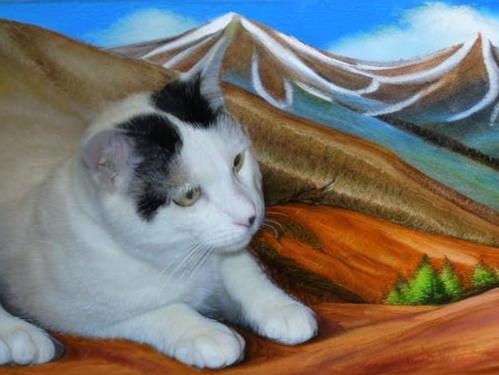

In [14]:
result["generated_image"]

#Classifier

In [17]:
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

In [4]:
# Data Preparation

print(dataset["train"].filter(lambda x: x["labels"] == 0))
print(dataset["train"].filter(lambda x: x["labels"] == 1))
print(dataset["test"].filter(lambda x: x["labels"] == 0))
print(dataset["test"].filter(lambda x: x["labels"] == 1))

Dataset({
    features: ['image', 'labels'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 4000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 1000
})
Dataset({
    features: ['image', 'labels'],
    num_rows: 1000
})


In [5]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [6]:
class HuggingFaceDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),  # Convert PIL image to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Assuming the path to the image is stored under the key 'file'
        image = self.transforms(image)
        # Assuming there's a key 'label' in the sample dict for the label
        label = torch.tensor(sample['labels'], dtype=torch.long)
        return image, label

In [7]:
# Example usage:
# Assuming 'huggingface_dataset' is your dataset obtained from Hugging Face
torch_train_dataset = HuggingFaceDataset(train_dataset)
torch_test_dataset = HuggingFaceDataset(test_dataset)

In [8]:
len(torch_test_dataset)

2000

In [9]:
train_split = 7000
validation_split = 1000

In [10]:
train_ds, val_ds = random_split(torch_train_dataset,[train_split, validation_split])

In [11]:
batch_size = 8

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


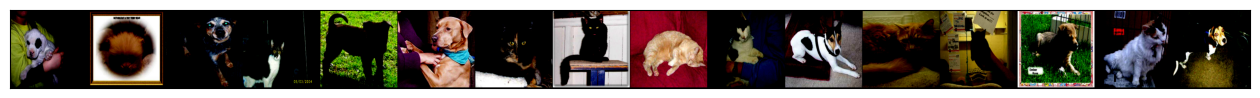

In [62]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    images, labels = next(iter(dl))
    fig,ax = plt.subplots(figsize = (16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))


show_batch(train_dl)
# type(train_ds)

In [13]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class DogsvsCatsClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(262144,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )

    def forward(self, xb):
        return self.network(xb)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [19]:
model = DogsvsCatsClassifier()

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/875 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  6%|▌         | 54/875 [13:15<3:24:03, 14.91s/it]